In [1]:
modelName = 'resnet152'
filterName = 'None'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = models.resnet152(pretrained=True)
    
model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 35
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=100, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=80, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 35 | Train loss: 0.03323954523234333 | Val loss: 0.011261706127044864
Epoch: 2 / 35 | Train loss: 0.014592001127195078 | Val loss: 0.009967838405058362
Epoch: 3 / 35 | Train loss: 0.010116537450812757 | Val loss: 0.00713591629307932
Epoch: 4 / 35 | Train loss: 0.00900051102157211 | Val loss: 0.006667262199931802
Epoch: 5 / 35 | Train loss: 0.007227317876688366 | Val loss: 0.00674024247788251
Epoch: 6 / 35 | Train loss: 0.00618071397090888 | Val loss: 0.006946253582823257
Epoch: 7 / 35 | Train loss: 0.0055418971293170124 | Val loss: 0.006323395198052868
Epoch: 8 / 35 | Train loss: 0.005543608064262989 | Val loss: 0.0051873477790743494
Epoch: 9 / 35 | Train loss: 0.005418533605759978 | Val loss: 0.005575697057140179
Epoch: 10 / 35 | Train loss: 0.0041396121176433785 | Val loss: 0.005890562605017271
Epoch: 11 / 35 | Train loss: 0.004029088974935022 | Val loss: 0.004992063080396456
Epoch: 12 / 35 | Train loss: 0.004412261766779431 | Val loss: 0.007067033229992749
Epoch: 13 / 35 

26


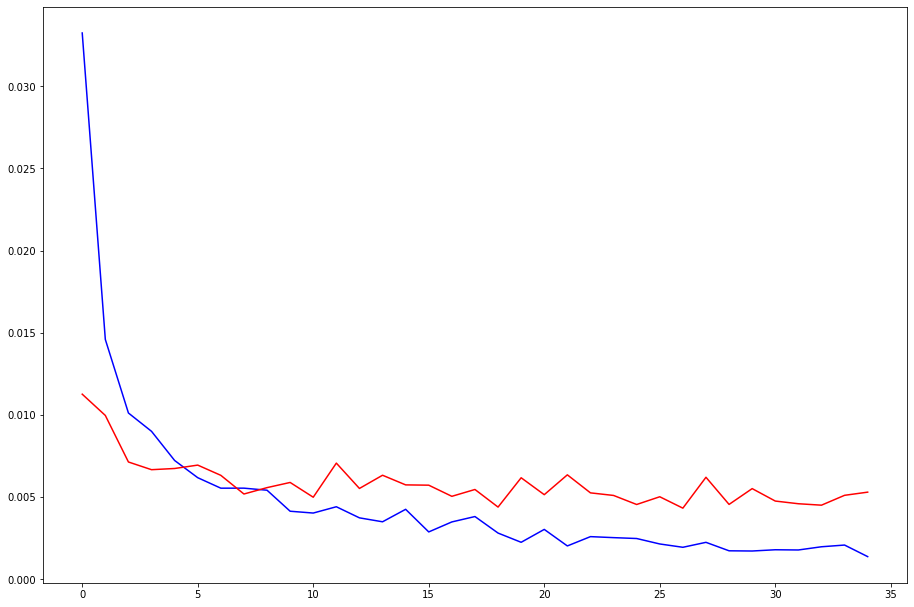

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = models.resnet152(pretrained=True)
    
model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}.pt'))

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=80, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 6min 38s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)

In [17]:
predict_df

filename      model filter  v   predict  \
0       b8361558-8c43-4f06-bab5-1079aa99406e  resnet152   None  0  0.000019   
1       168d4fa8-68c6-4b93-a849-5aed5ab68d11  resnet152   None  0  0.000018   
2       f20ed054-920a-4fa2-b4fb-5fc661c557b7  resnet152   None  0  0.000017   
3       5c08522a-f5bb-4abc-872c-a2547accfd71  resnet152   None  0  0.000019   
4       5ab05a17-1647-4840-8d62-0c3d12003786  resnet152   None  0  0.000013   
...                                      ...        ...    ... ..       ...   
528315  c5ef5924-345e-428c-b434-e3902f81482f  resnet152   None  3  0.000104   
528316  82b57bb8-d382-4bb0-86c8-8ee25841497b  resnet152   None  3  0.000019   
528317  32ec7db7-88f4-4d9b-8229-6a89a3bb5192  resnet152   None  3  0.000020   
528318  6b45adf9-4527-4e3d-ac35-5b8c06fa4f1f  resnet152   None  3  0.000021   
528319  6c6c25f2-a64c-4a0e-8e51-7e5d3d11198e  resnet152   None  3  0.000014   

        sign  
0       -1.0  
1       -1.0  
2       -1.0  
3       -1.0  
4       -1.0  
...      ...  
528315   0.0  
528316  -1.0  
528317  -1.0  
528318  -1.0  
528319  -1.0  

[528320 rows x 6 columns]

In [18]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}.csv', index=False)